In [10]:
from ccdproc import (CCDData, ImageFileCollection)
from scipy import (signal, interpolate)
import os
import glob
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits.header import Header

import sys
sys.path.append('/user/simon/development/soar/goodman')

# import goodman
from pipeline.core import (read_fits, write_fits)
from pipeline.wcs.wcs import WCS

plt.rcParams["figure.figsize"] = [16,9]

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
GSP_VERS= '1.0b2   '           / Goodman Spectroscopic Pipeline Version         GSP_ONAM= '0171_HD177409_G1200M2_slit103.fits' / Original file name             GSP_PNAM= 'cfzsto_0171_HD177409_G1200M2_slit103.fits' / Parent file name        GSP_FNAM= 'gcfzsto_0171_HD177409_G1200M2_slit103.fits' / Current file name      GSP_PATH= '/data/simon/data/soar/work/aller/2017-06-11' / Location at moment of GSP_TECH= 'Spectroscopy'       / Observing technique                            GSP_DATE= '2018-01-25'         / Processing date                                GSP_OVER= '[1:16,1:1896]'      / Overscan region                                GSP_TRIM= '[51:4110,1:1896]'   / Trimsection from TRIMSEC                       GSP_SLIT= '[1:4060,135:1672]'  / Slit trim section, slit illuminated area only. GSP_BIAS= 'master_bias_2.fits' / Master bias image                              GS

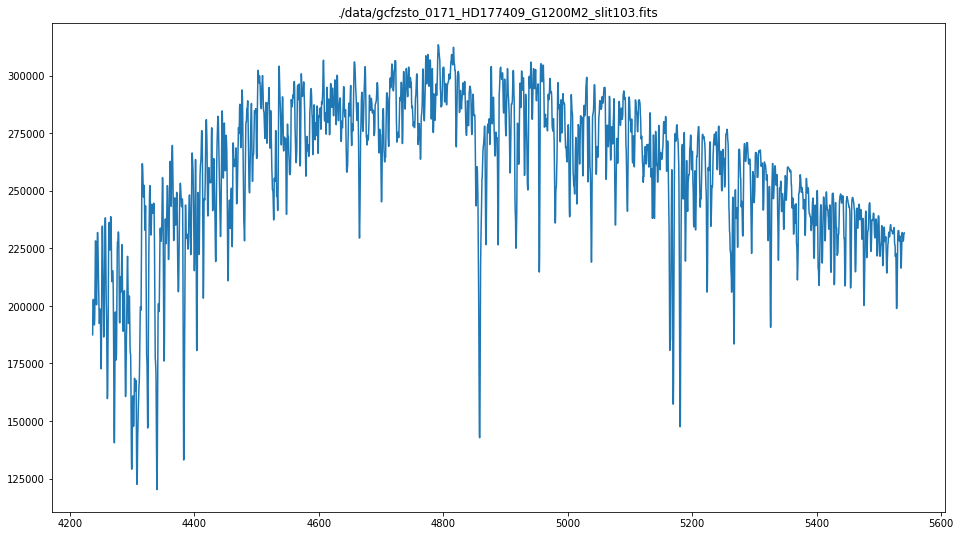

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
GSP_VERS= '1.0b2   '           / Goodman Spectroscopic Pipeline Version         GSP_ONAM= '0171_HD177409_G1200M2_slit103.fits' / Original file name             GSP_PNAM= '0171_HD177409_G1200M2_slit103.fits' / Parent file name               GSP_FNAM= 'cfzsto_0171_HD177409_G1200M2_slit103.fits' / Current file name       GSP_PATH= '/data/simon/data/soar/work/aller/2017-06-11' / Location at moment of GSP_TECH= 'Spectroscopy'       / Observing technique                            GSP_DATE= '2018-01-25'         / Processing date                                GSP_OVER= '[1:16,1:1896]'      / Overscan region                                GSP_TRIM= '[51:4110,1:1896]'   / Trimsection from TRIMSEC                       GSP_SLIT= '[1:4060,135:1672]'  / Slit trim section, slit illuminated area only. GSP_BIAS= 'master_bias_2.fits' / Master bias image                              GS

AttributeError: 'NoneType' object has no attribute 'wcs'

In [20]:
files = glob.glob('./data/g*fits')
wcs = WCS()
assert isinstance(wcs, WCS)
all_data = []
for file_name in files:
    ccd = CCDData.read(file_name, unit=u.adu)
    print(ccd.header["GSP_*"])
    wav, intens = wcs.read(ccd=ccd)
    all_data.append([wav, intens])
    plt.title(file_name)
    plt.plot(wav, intens)
    plt.show()
    

# Attempt to extract from Data

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
1538 4060
Model: Gaussian1D
Name: Gaussian_776
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude    mean    stddev  
    ------------- ----- -----------
    18200.1269531 776.0 6.076487004
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
         c0              c1                c2       
    ------------ ----------------- -----------------
    786.45440967 -0.00497729892796 1.27611659091e-07


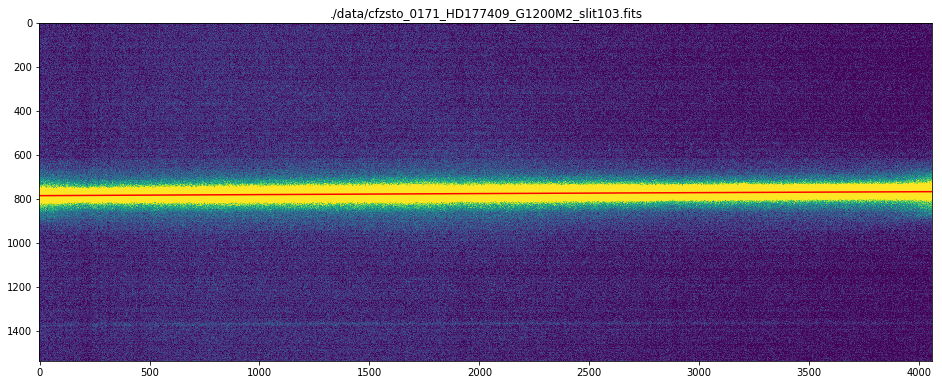

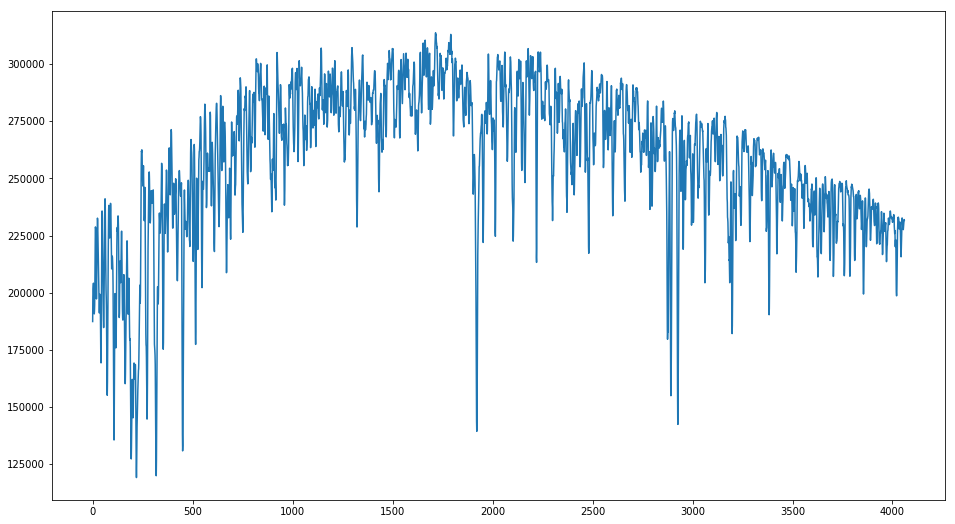

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
1537 4060
Model: Gaussian1D
Name: Gaussian_778
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude    mean    stddev   
    ------------- ----- ------------
    25339.2070312 778.0 4.7411505879
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
          c0              c1                c2        
    ------------- ----------------- ------------------
    788.317963152 -0.00367751912956 -6.46205167351e-08


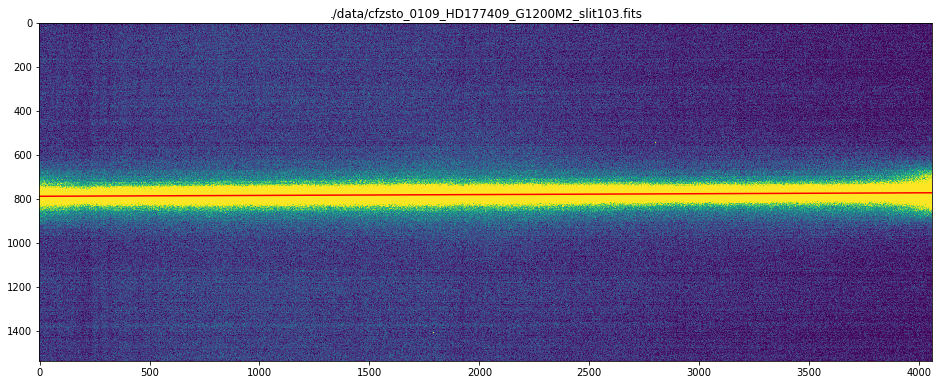

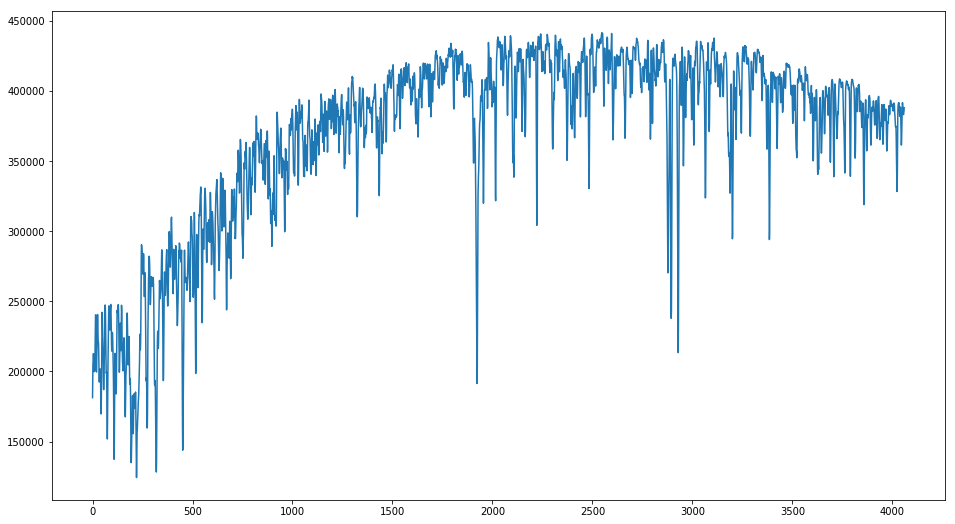

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
1537 4060
Model: Gaussian1D
Name: Gaussian_791
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude    mean     stddev   
    ------------- ----- -------------
    10355.5458984 791.0 4.35419592731
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
          c0              c1                c2        
    ------------- ----------------- ------------------
    800.987142731 -0.00303007390316 -1.80327901544e-07


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


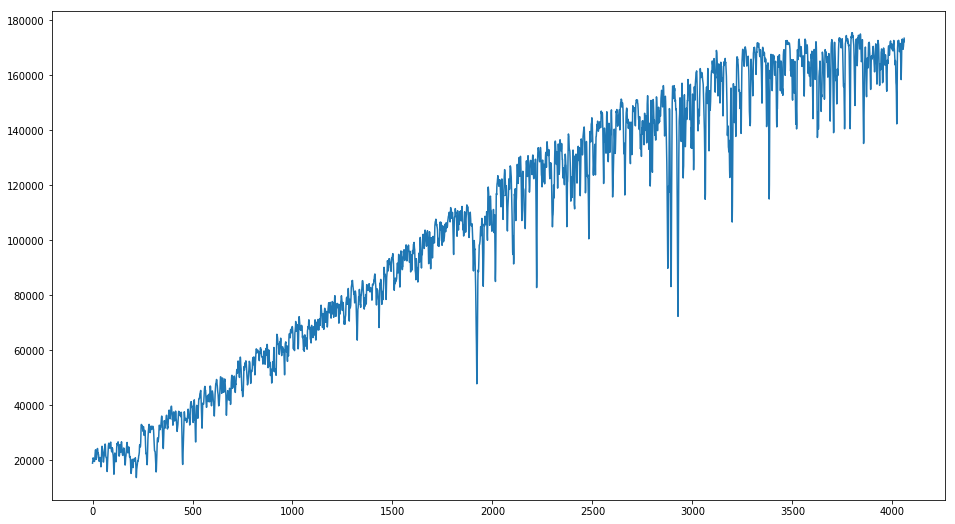

In [35]:
sys.path.append('/user/simon/development/soar/goodman')

# import goodman
from pipeline.core import identify_targets, trace ,extraction
from astropy.modeling import models, fitting
import glob
# from goodman.pipeline.core import extraction

plt.rcParams["figure.figsize"] = [16,9]
n_sigmas = 3

images = glob.glob("./data/c*fits")
for image in images:
    ccd = CCDData.read(image, unit=u.adu)
    spatial, dispersion = ccd.data.shape
    print(spatial, dispersion)
    
    target = identify_targets(ccd=ccd)
    print(target[0])
    trace_model  = models.Polynomial1D(degree=2)
    trace_fitter = fitting.LevMarLSQFitter()

    traces = trace(ccd=ccd,
                   model=target[0],
                   trace_model=trace_model,
                   fitter=trace_fitter,
                   sampling_step=5)
    print(traces)
    extracted= extraction(ccd=ccd,
                          trace=traces,
                          spatial_profile=target[0],
                          extraction='fractional')
    # print(traces)
    
    
    plt.title(image)
    plt.plot(traces(range(dispersion)), color='r')
    plt.imshow(ccd.data, clim=(5, 80))
    plt.show()
    
    plt.plot(extracted.data)
    plt.show()
